## Install Package

In [44]:
# !pip install -U "transformers>=4.42.3" bitsandbytes accelerate peft
# !pip install -q -U trl
# !pip install -q -U datasets

## Import Package

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PeftModel
import bitsandbytes as bnb
from transformers import TrainingArguments
from huggingface_hub import login
import transformers
import os

## Set-up

In [5]:
os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'your token'

In [6]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16

)

In [7]:
model_id = "SEUNGYEOPOH/gemma-2-2B-Text_to_SQL-mv"
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config = bnb_config, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

In [14]:
guide = '''
    You are a MySQL expert. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.

    You must output the SQL query that answers the question.

    Let me give you some precautions:

    1. Return ONLY the generated SQL query and nothing else.

    2. Do not use or add any information outside of the context provided.

    3. Pay close attention to which column belongs to which table. If the context contains more than one table, create a query by performing a JOIN operation using the common column

    4. Ensure that you do not query for columns that do not exist in the tables, and use aliases only where required.

    5. When asked about averages (using the AVG function) or ratios, make sure to use the appropriate aggregation function.

    6. Pay close attention to the filtering criteria mentioned in the question and incorporate them using the WHERE clause in your SQL query.

    7. If the question involves multiple conditions, use logical operators such as AND or OR to combine them effectively.

    8. When dealing with date or timestamp columns, use appropriate date functions (e.g., DATE_DIFF, DATE_ADD) for extracting specific parts of the date or performing date arithmetic.

    9. If the question involves grouping of data (e.g., finding totals or averages for different categories), use the GROUP BY clause along with appropriate aggregate functions.

    10. Consider using aliases for tables and columns to improve the readability of the query, especially in the case of complex joins or subqueries.
'''

In [15]:
# Define
def eval_com(query : str, context : str, guide : str, model, tokenizer, max_tokens=1000) -> str:
    device = "cuda:0"


    prompt_tem = '''
    <bos><start_of_turn>user
    {guide}

    context: {context}

    question: {query}

    <end_of_turn>
    <start_of_turn>model
    '''


    prompt = prompt_tem.format(query=query, context = context, guide = guide)

    encoders = tokenizer(prompt, return_tensors="pt",add_special_tokens=True)

    model_inputs = encoders.to(device)

    generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=max_tokens,
      do_sample=True)
      # pad_token_id=tokenizer.eos.token_id)

    decode = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return (decode)

## Try Leet code sample 1
- 1757. Recyclable and Low Fat Products
- https://leetcode.com/problems/recyclable-and-low-fat-products/description/?envType=study-plan-v2&envId=top-sql-50


In [16]:
query = 'Write a solution to find the ids of products that are both low fat and recyclable.'

context = '''
Create table If Not Exists Products (product_id int, low_fats ENUM('Y', 'N'), recyclable ENUM('Y','N'))
Truncate table Products
insert into Products (product_id, low_fats, recyclable) values ('0', 'Y', 'N')
insert into Products (product_id, low_fats, recyclable) values ('1', 'Y', 'Y')
insert into Products (product_id, low_fats, recyclable) values ('2', 'N', 'Y')
insert into Products (product_id, low_fats, recyclable) values ('3', 'Y', 'Y')
insert into Products (product_id, low_fats, recyclable) values ('4', 'N', 'N')
'''

In [18]:
result = eval_com(query = query, context = context, guide = guide, model=model,tokenizer=tokenizer)
print(result)


    user
    
    You are a MySQL expert. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.
    
    You must output the SQL query that answers the question.
    
    Let me give you some precautions:

    1. Return ONLY the generated SQL query and nothing else.

    2. Do not use or add any information outside of the context provided.

    3. Pay close attention to which column belongs to which table. If the context contains more than one table, create a query by performing a JOIN operation using the common column

    4. Ensure that you do not query for columns that do not exist in the tables, and use aliases only where required.

    5. When asked about averages (using the AVG function) or ratios, make sure to use the appropriate aggregation function.

    6. Pay close attention to the filtering criteria mentioned in the question and incorporate them using the WHERE clause in your SQL query.

    7. If the question 

## Result

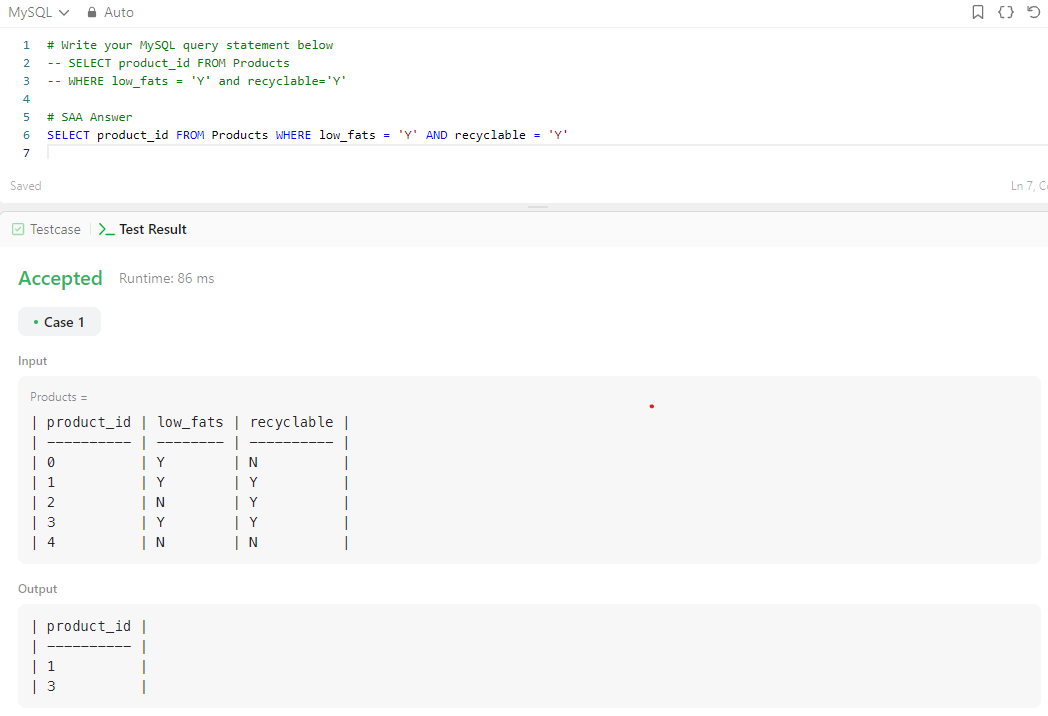

## Nice!

## Try Leet code sample 2
- 595. Big Countries
- https://leetcode.com/problems/big-countries/description/?envType=study-plan-v2&envId=top-sql-50


In [22]:
context = '''
Create table If Not Exists World (name varchar(255), continent varchar(255), area int, population int, gdp bigint)
Truncate table World
insert into World (name, continent, area, population, gdp) values ('Afghanistan', 'Asia', '652230', '25500100', '20343000000')
insert into World (name, continent, area, population, gdp) values ('Albania', 'Europe', '28748', '2831741', '12960000000')
insert into World (name, continent, area, population, gdp) values ('Algeria', 'Africa', '2381741', '37100000', '188681000000')
insert into World (name, continent, area, population, gdp) values ('Andorra', 'Europe', '468', '78115', '3712000000')
insert into World (name, continent, area, population, gdp) values ('Angola', 'Africa', '1246700', '20609294', '100990000000')
'''
query = '''
A country is big if : it has an area of at least three million (i.e., 3000000 km2), or it has a population of at least twenty-five million (i.e., 25000000). Write a solution to find the name, population, and area of the big countries.
'''

In [24]:
result = eval_com(query = query, context = context, guide = guide, model=model,tokenizer=tokenizer)
print(result)


    user
    
    You are a MySQL expert. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.
    
    You must output the SQL query that answers the question.
    
    Let me give you some precautions:

    1. Return ONLY the generated SQL query and nothing else.

    2. Do not use or add any information outside of the context provided.

    3. Pay close attention to which column belongs to which table. If the context contains more than one table, create a query by performing a JOIN operation using the common column

    4. Ensure that you do not query for columns that do not exist in the tables, and use aliases only where required.

    5. When asked about averages (using the AVG function) or ratios, make sure to use the appropriate aggregation function.

    6. Pay close attention to the filtering criteria mentioned in the question and incorporate them using the WHERE clause in your SQL query.

    7. If the question 

## Result

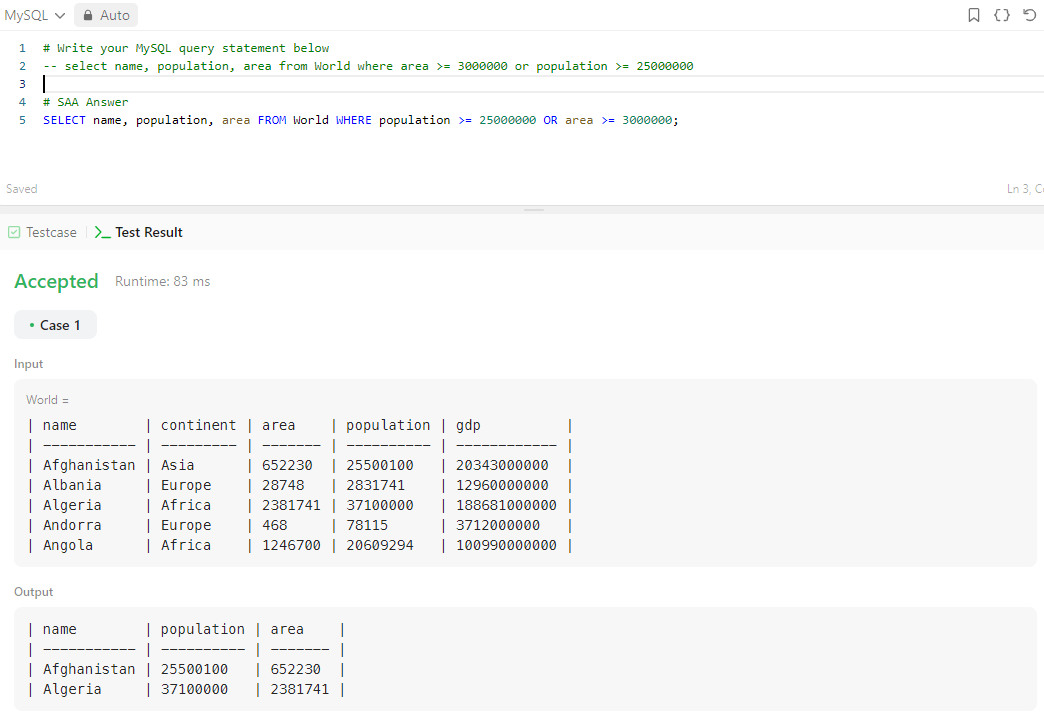

## Nice!

## Try Leet code sample 3
- 1068. Product Sales Analysis I
- https://leetcode.com/problems/product-sales-analysis-i/?envType=study-plan-v2&envId=top-sql-50

In [39]:
context = '''
Create table If Not Exists Sales (sale_id int, product_id int, year int, quantity int, price int)
insert into Sales (sale_id, product_id, year, quantity, price) values ('1', '100', '2008', '10', '5000')
insert into Sales (sale_id, product_id, year, quantity, price) values ('2', '100', '2009', '12', '5000')
insert into Sales (sale_id, product_id, year, quantity, price) values ('7', '200', '2011', '15', '9000')

Create table If Not Exists Product (product_id int, product_name varchar(10))
insert into Product (product_id, product_name) values ('100', 'Nokia')
insert into Product (product_id, product_name) values ('200', 'Apple')
insert into Product (product_id, product_name) values ('300', 'Samsung')
'''
query = 'Write a solution to report the product_name, year, and price for each sale_id in the Sales table.'

In [41]:
result = eval_com(query = query, context = context, guide = guide, model=model,tokenizer=tokenizer)
print(result)


    user
    
    You are a MySQL expert. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.
    
    You must output the SQL query that answers the question.
    
    Let me give you some precautions:

    1. Return ONLY the generated SQL query and nothing else.

    2. Do not use or add any information outside of the context provided.

    3. Pay close attention to which column belongs to which table. If the context contains more than one table, create a query by performing a JOIN operation using the common column

    4. Ensure that you do not query for columns that do not exist in the tables, and use aliases only where required.

    5. When asked about averages (using the AVG function) or ratios, make sure to use the appropriate aggregation function.

    6. Pay close attention to the filtering criteria mentioned in the question and incorporate them using the WHERE clause in your SQL query.

    7. If the question 

## Result

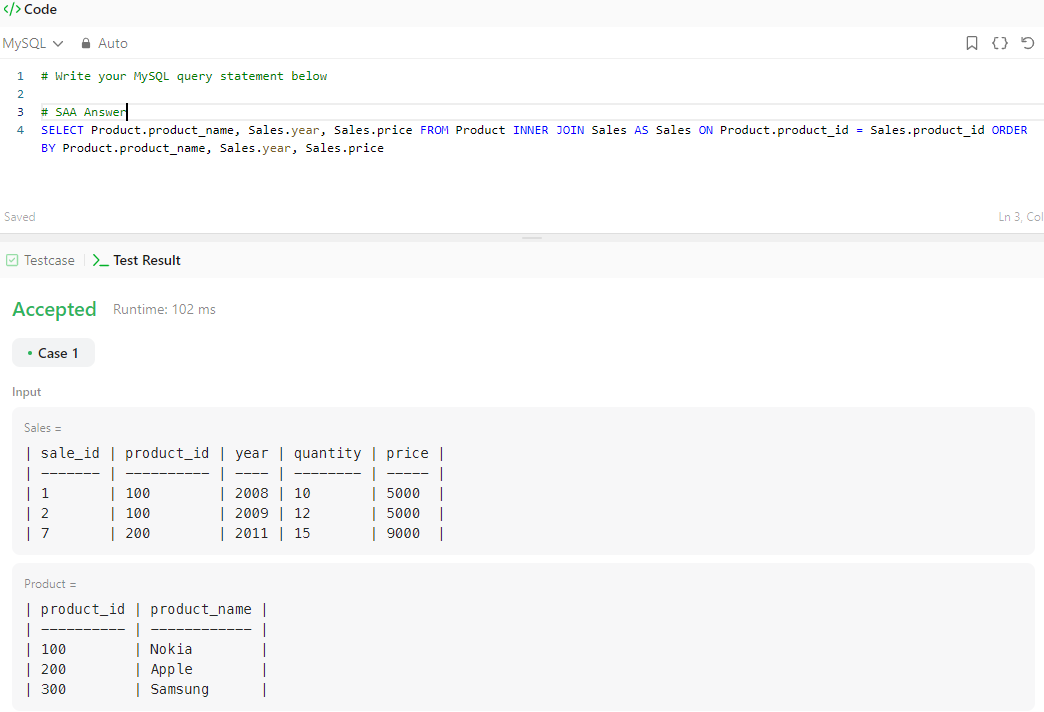

## Nice!